#### imports for Q4

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import griddata
from scipy.spatial.distance import cdist
from scipy.stats import chi2, norm
import seaborn as sns

# Sample Multivariate Data

#### Helper functions for sampling Multivariate Normal Data

In [2]:
def mn_sample_generator(mean, covar, n_samples):
    L = np.linalg.cholesky(covar)
    Z = np.random.normal(size=(n_samples, covar.shape[0]))
    return Z.dot(L) + mean

def multivariate_normal_distribution(samples, mean, covar, N):
    distribution = []
    for sample in samples:
        sample_m = sample - mean
        covar_det = np.linalg.det(covar)
        covar_inv = np.linalg.inv(covar)
        pdf = (1./np.sqrt((2*np.pi)**N)*covar_det) * np.exp(-0.5*(sample_m).T.dot(covar_inv).dot(sample_m))
        distribution.append(pdf)
    return np.array(distribution)

In [3]:
N = 3
n_samples = 100
X = np.random.normal(size=(N,1))
covar = np.exp(-cdist(X,X, "sqeuclidean")) + 1e-6 + np.eye(X.shape[0])
mean = np.zeros((X.shape[0], ))
samples = mn_sample_generator(mean, covar, n_samples)
samples_df = pd.DataFrame(samples)
distribution = multivariate_normal_distribution(samples, mean, covar, N)

In [4]:
samples.shape

(100, 3)

In [5]:
np.max(samples), np.min(samples)

(4.226687095781805, -3.511850577908309)

In [6]:
np.mean(samples), np.cov(samples.T)

(-0.0480253905468753,
 array([[3.20867243, 1.06045326, 0.73354939],
        [1.06045326, 1.45270782, 0.32259415],
        [0.73354939, 0.32259415, 1.40118814]]))

#### Plot showing the sample points distributed in a 3D-space

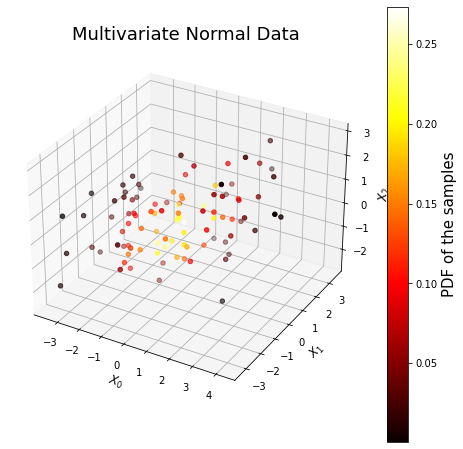

In [7]:
fig3 = plt.figure(figsize=(8,8))
ax3 = fig3.add_subplot(111, projection='3d')
ax3.set_title('Multivariate Normal Data', fontsize=18)
zAx = samples_df[2]
yAx = samples_df[1]
xAx = samples_df[0]
val = distribution
ax3.set_xlabel('$X_0$', fontsize=12)
ax3.set_ylabel('$X_1$', fontsize=12)
ax3.set_zlabel('$X_2$', fontsize=12)
img = ax3.scatter(xAx, yAx, zAx, c=val, cmap=plt.hot())
cbar = fig3.colorbar(img)
cbar.set_label('PDF of the samples', fontsize=15)
plt.show()

#### Plot showing distributions that the N variables follow

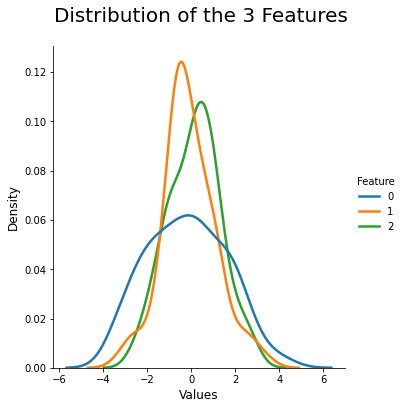

In [8]:
fig1 = sns.displot(data=samples_df, kind='kde', linewidth=2.5, height=5)
fig1.set_axis_labels("Values", "Density", fontsize=12)
fig1.fig.suptitle("Distribution of the 3 Features", fontsize=20, y=1.08)
fig1._legend.set_title('Feature')
plt.show()

#### A correlation matrix between all variables

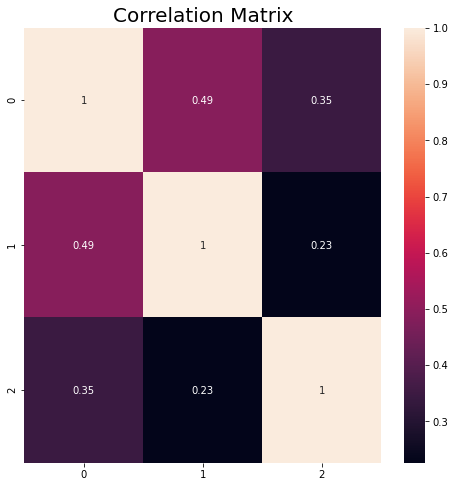

In [9]:
plt.figure(figsize = (8,8))
corr = samples_df.corr()
corr_matrix = sns.heatmap(corr, annot=True)
corr_matrix.set_title('Correlation Matrix', fontsize=20)
plt.show()

## Univariate Marginal Tests using Q-Q plot


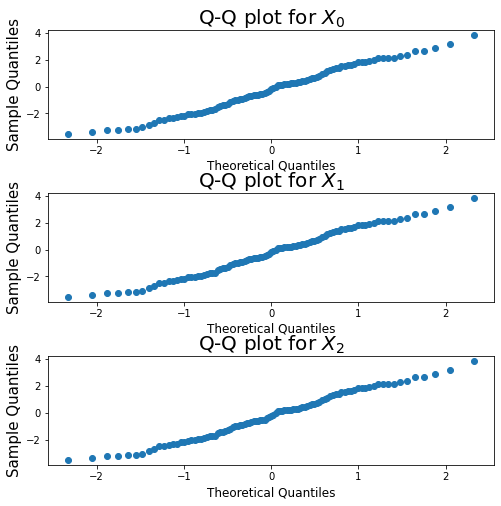

In [17]:
norm_quantiles = norm_quantiles = norm.ppf([(i+1)/n_samples for i in range(n_samples)])
fig5, ax5 = plt.subplots(3,1, figsize=(10,20))
for i in range(N):
    ax5[i].scatter(norm_quantiles, np.sort(samples[:,0]))
    ax5[i].set_title("Q-Q plot for $X_{}$".format(i), fontsize=20)
    ax5[i].set_xlabel("Theoretical Quantiles".format(i), fontsize=12)
    ax5[i].set_ylabel("Sample Quantiles".format(i), fontsize=15)
fig5.subplots_adjust(hspace=.5)
plt.show()

# Bivariate Normality
This is done by plotting the contours for each pair of variable 

#### A scattered pair plot for all features

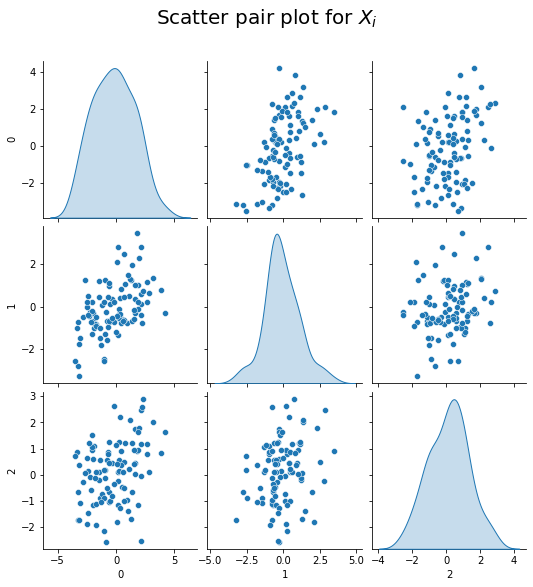

In [11]:
fig4 = sns.pairplot(samples_df, diag_kind='kde')
fig4.fig.suptitle("Scatter pair plot for $X_i$", fontsize=20, y=1.08)
plt.show()

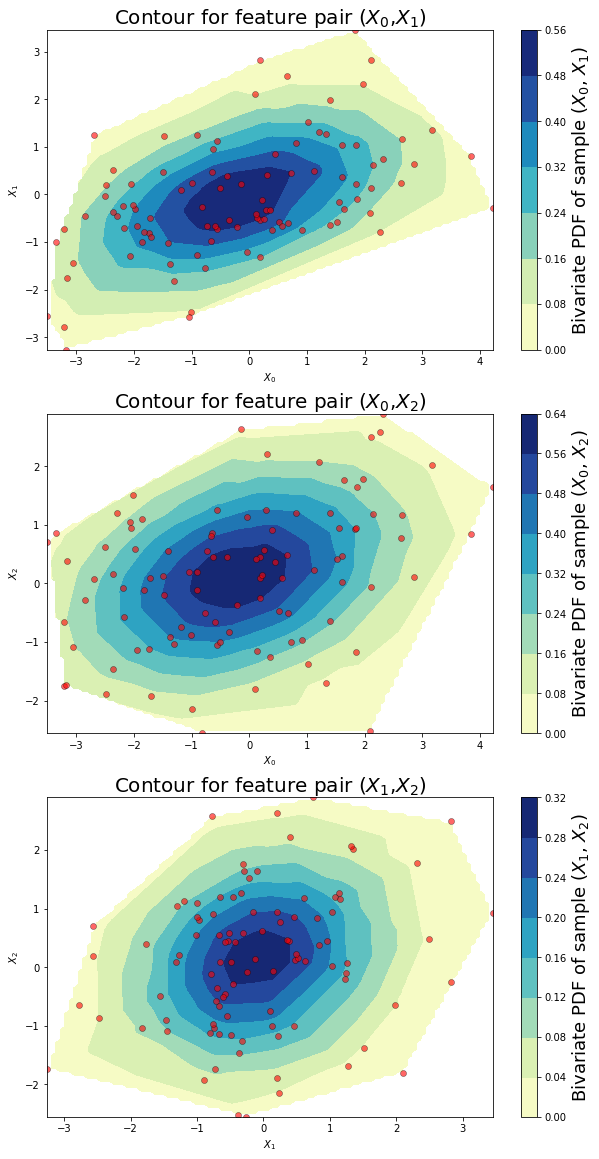

In [12]:
pairs = [(i,j) for i in range(N-1) for j in range(i+1, N)]
fig6, ax6 = plt.subplots(len(pairs),1, figsize=(10,20))
for i in range(len(pairs)):
    x6, y6 = samples[:, pairs[i][0]], samples[:, pairs[i][1]]
    submatrix = samples_df[[pairs[i][0],pairs[i][1]]].values
    z6 = multivariate_normal_distribution(submatrix, np.mean(submatrix, axis=0), np.cov(submatrix.T), N=2) 
    x6grid = np.linspace(x6.min(), x6.max(), n_samples)
    y6grid = np.linspace(y6.min(), y6.max(), n_samples)
    x6grid, y6grid = np.meshgrid(x6grid, y6grid)
    z6grid = griddata((x6,y6),z6, (x6grid, y6grid))
    img = ax6[i].contourf(x6grid, y6grid, z6grid, cmap=cm.YlGnBu)
    ax6[i].set_title('Contour for feature pair ($X_{}$,$X_{}$)'.format(pairs[i][0],pairs[i][1]), fontsize=20)
    ax6[i].set_xlabel("$X_{}$".format(pairs[i][0]))
    ax6[i].set_ylabel("$X_{}$".format(pairs[i][1]))
    ax6[i].plot(samples[:,pairs[i][0]], samples[:, pairs[i][1]], 'ro', alpha=.6, markeredgecolor='k', markeredgewidth=0.5)
    cbar = plt.colorbar(img, ax=ax6[i])
    cbar.set_label('Bivariate PDF of sample ($X_{}$, $X_{}$)'.format(pairs[i][0], pairs[i][1]), fontsize=18)

# Mutilvariate Normality

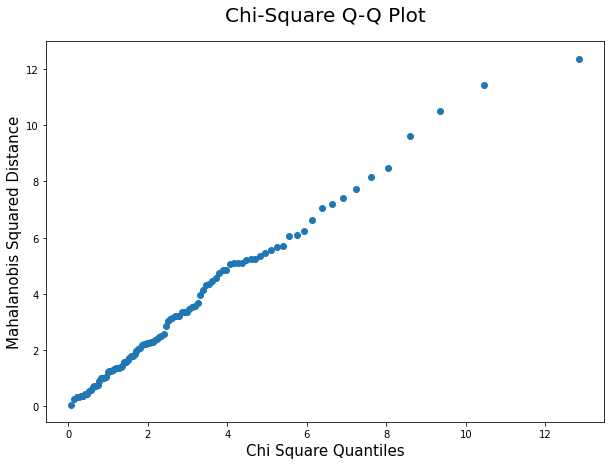

In [13]:
def mahalanobis_squared_distance():
    distances = np.zeros(n_samples)
    for i in range(n_samples): 
        sample_m = samples[i] - mean
        covar_inv = np.linalg.inv(covar)
        dist = (sample_m).T.dot(covar_inv).dot(sample_m)
        distances[i] = dist
    return np.sort(distances)

def chiSq_quantiles():
    quantiles = chi2.ppf([(i-0.5)/n_samples for i in range(1,n_samples+1)], N)
    return quantiles

quantiles = chiSq_quantiles()
mahalanobis_distances = mahalanobis_squared_distance()
fig7 = plt.figure(figsize=(10,7))
plt.scatter(quantiles, mahalanobis_distances)
plt.title('Chi-Square Q-Q Plot', fontsize=20, pad=20)
plt.xlabel('Chi Square Quantiles', fontsize=15)
plt.ylabel('Mahalanobis Squared Distance', fontsize=15)
plt.show()